In [1]:
import nltk
import dill
import tqdm
import pprint
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from nltk.corpus import treebank
from nltk.tag import CRFTagger
from nltk.tag import HiddenMarkovModelTrainer
from nltk.tag import PerceptronTagger
from nltk.tag import TnT
nltk.download('treebank')

MODELS_PATH = Path("./models")

[nltk_data] Downloading package treebank to /Users/victor/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [2]:
def saveModel(model, path):
    with open(path, "wb") as f:
        dill.dump(model, f)

def evaluateModel(testData, model, print_=True):
    acc = round(model.evaluate(testData), 3)
    if print_:
        print('accuracy: ' + str(acc))
    return acc

def trainHMM(trainData, modelPath):
    trainer = HiddenMarkovModelTrainer()
    HMM = trainer.train_supervised(trainData)
    saveModel(HMM, modelPath)
    return HMM

def trainTnT(trainData, modelPath):
    tnT = TnT()
    tnT.train(trainData)
    saveModel(tnT, modelPath)
    return tnT

def trainPerceptron(trainData, modelPath):
    PER = PerceptronTagger(load=False)
    PER.train(trainData)
    saveModel(PER, modelPath)
    return PER

def trainCRF(trainData, modelPath):
    CRF = CRFTagger()
    CRF.train(trainData, str(modelPath))
    return CRF


In [3]:
models = {k:dict() for k in ("HMM", "TnT", "PER", "CRF")}
for model in models:
    Path(MODELS_PATH / model).mkdir(parents=True, exist_ok=True)

In [4]:
for numTrainingSentences in tqdm.tqdm(range(500, 3001, 500)):
    trainData = treebank.tagged_sents()[:numTrainingSentences]
    models['HMM'][numTrainingSentences] = trainHMM(trainData, MODELS_PATH / "HMM" / f'hmm_{numTrainingSentences}')
    models['TnT'][numTrainingSentences] = trainTnT(trainData, MODELS_PATH / "TnT" / f'tnt_{numTrainingSentences}')
    models['PER'][numTrainingSentences] = trainPerceptron(trainData, MODELS_PATH / "PER" / f'per_{numTrainingSentences}')
    models['CRF'][numTrainingSentences] = trainCRF(trainData, MODELS_PATH / "CRF" / f'crf_{numTrainingSentences}')
print()
pprint.pprint(models)

100%|██████████| 6/6 [03:00<00:00, 30.13s/it]
{'CRF': {500: <nltk.tag.crf.CRFTagger object at 0x12163de10>,
         1000: <nltk.tag.crf.CRFTagger object at 0x122b59990>,
         1500: <nltk.tag.crf.CRFTagger object at 0x12667e3d0>,
         2000: <nltk.tag.crf.CRFTagger object at 0x123112710>,
         2500: <nltk.tag.crf.CRFTagger object at 0x12c2a27d0>,
         3000: <nltk.tag.crf.CRFTagger object at 0x1274ccb10>},
 'HMM': {500: <HiddenMarkovModelTagger 42 states and 3305 output symbols>,
         1000: <HiddenMarkovModelTagger 44 states and 5391 output symbols>,
         1500: <HiddenMarkovModelTagger 45 states and 6913 output symbols>,
         2000: <HiddenMarkovModelTagger 46 states and 8579 output symbols>,
         2500: <HiddenMarkovModelTagger 46 states and 9786 output symbols>,
         3000: <HiddenMarkovModelTagger 46 states and 10779 output symbols>},
 'PER': {500: <nltk.tag.perceptron.PerceptronTagger object at 0x121390ed0>,
         1000: <nltk.tag.perceptron.Percept

In [5]:
def loadDillModel(path):
    with open(path, "rb") as f:
        return dill.load(f)

def loadCrfModel(path):
    CRF = CRFTagger()
    CRF.set_model_file(str(path))
    return CRF

def loadModels():
    models = {k: dict() for k in ("HMM", "TnT", "PER", "CRF")}
    for numTrainingSentences in range(500, 3001, 500):
        models["HMM"][numTrainingSentences] = loadDillModel(MODELS_PATH / "HMM" / f'hmm_{numTrainingSentences}')
        models["TnT"][numTrainingSentences] = loadDillModel(MODELS_PATH / "TnT" / f'tnt_{numTrainingSentences}')
        models["PER"][numTrainingSentences] = loadDillModel(MODELS_PATH / "PER" / f'per_{numTrainingSentences}')
        models["CRF"][numTrainingSentences] = loadCrfModel(MODELS_PATH / "CRF" / f'crf_{numTrainingSentences}')
    return models

In [6]:
models = loadModels()
pprint.pprint(models)

{'CRF': {500: <nltk.tag.crf.CRFTagger object at 0x128e14c90>,
         1000: <nltk.tag.crf.CRFTagger object at 0x12aa9de90>,
         1500: <nltk.tag.crf.CRFTagger object at 0x129095f50>,
         2000: <nltk.tag.crf.CRFTagger object at 0x133b0bbd0>,
         2500: <nltk.tag.crf.CRFTagger object at 0x136a85e50>,
         3000: <nltk.tag.crf.CRFTagger object at 0x1396da610>},
 'HMM': {500: <HiddenMarkovModelTagger 42 states and 3305 output symbols>,
         1000: <HiddenMarkovModelTagger 44 states and 5391 output symbols>,
         1500: <HiddenMarkovModelTagger 45 states and 6913 output symbols>,
         2000: <HiddenMarkovModelTagger 46 states and 8579 output symbols>,
         2500: <HiddenMarkovModelTagger 46 states and 9786 output symbols>,
         3000: <HiddenMarkovModelTagger 46 states and 10779 output symbols>},
 'PER': {500: <nltk.tag.perceptron.PerceptronTagger object at 0x1247152d0>,
         1000: <nltk.tag.perceptron.PerceptronTagger object at 0x1275ee4d0>,
         150

In [7]:
testData = treebank.tagged_sents()[3000:]
testAcc = {k: dict() for k in ("HMM", "TnT", "PER", "CRF")}
for modelType, modelsDict in models.items():
    for sentenceSize, model in modelsDict.items():
        acc = evaluateModel(testData, model, print_=False)
        testAcc[modelType][sentenceSize] = acc
        print(f"{modelType} trained with {sentenceSize} sentences: {acc}")

HMM trained with 500 sentences: 0.173
HMM trained with 1000 sentences: 0.221
HMM trained with 1500 sentences: 0.262
HMM trained with 2000 sentences: 0.304
HMM trained with 2500 sentences: 0.335
HMM trained with 3000 sentences: 0.368
TnT trained with 500 sentences: 0.747
TnT trained with 1000 sentences: 0.796
TnT trained with 1500 sentences: 0.827
TnT trained with 2000 sentences: 0.848
TnT trained with 2500 sentences: 0.862
TnT trained with 3000 sentences: 0.876
PER trained with 500 sentences: 0.911
PER trained with 1000 sentences: 0.934
PER trained with 1500 sentences: 0.942
PER trained with 2000 sentences: 0.95
PER trained with 2500 sentences: 0.953
PER trained with 3000 sentences: 0.957
CRF trained with 500 sentences: 0.91
CRF trained with 1000 sentences: 0.925
CRF trained with 1500 sentences: 0.933
CRF trained with 2000 sentences: 0.939
CRF trained with 2500 sentences: 0.943
CRF trained with 3000 sentences: 0.947


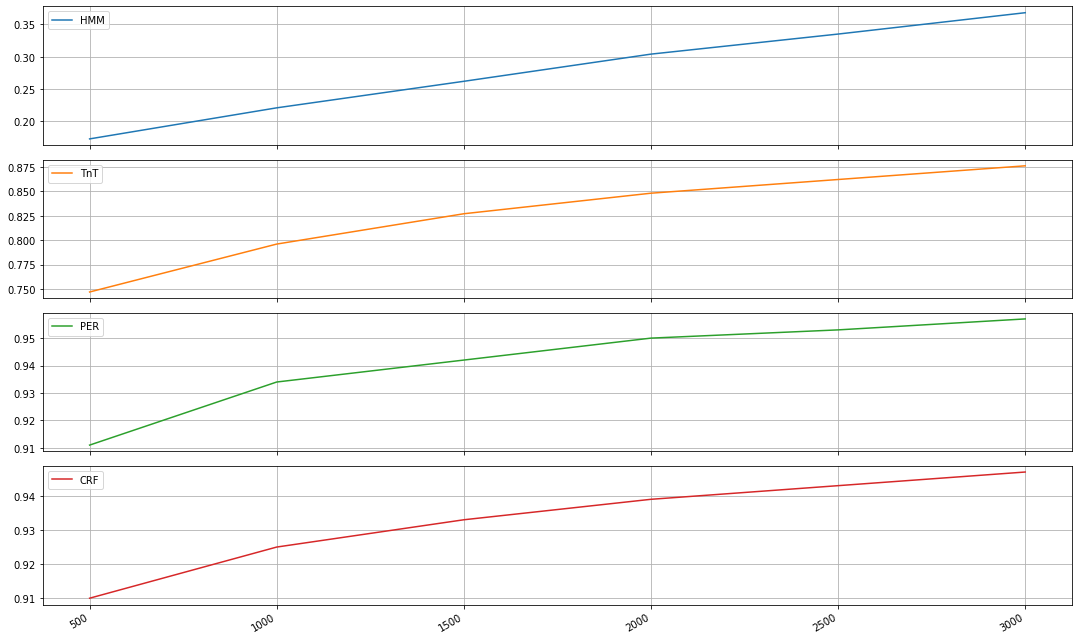

In [8]:
accDf = pd.DataFrame(testAcc)
accDf.to_csv("./test_accuracies.csv")
accDf.plot(subplots=True, figsize=(15, 9), grid='on')
plt.tight_layout()
plt.show()
